# Replication testing for csaQTL associations in independent datasets

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cna, pp, os, pickle
pp.umapprops['s'] = 0.4
import statsmodels.api as sm
from projection import *

fig_dir="/data/srlab/lrumker/MCSC_Project/cna-qtl/figs/"

# From Okabe & Ito, "colorblind-friendly" palette 
from matplotlib.colors import LinearSegmentedColormap
color_dict = {'orange': '#E69F00', 'skyblue': '#56B4E9', 'green': '#009E73', 
              'yellow': '#F0E442', 'purple': '#CC79A7', 'oceanblue': '#0072B2', 
              'vermillion': '#E63d00'} # O&I use '#D55E00'

## Table of replication cohorts

In [2]:
ref_studies = pd.DataFrame({"Publication": ['Randolph et al.', 'Perez et al.', 'Randolph et al.', 
                                            'Oelen et al.', 'Perez et al.'],
                           "Cohort": ['AFR', 'ASI', 'EUR', 'EUR', 'EUR'], 
                           "N, NK dataset": [38, 98, 41, 103, 139], 
                           "N, Myeloid dataset": [42, 98, 44, 104, 140],
                            "Cells, NK dataset": [2544, 23817, 3687, 16731, 40201],
                           "Cells, Myeloid dataset": [6055, 115912, 7988, 22441, 154527]})
table_latex = ref_studies.to_latex(index = False,  escape=False,
              column_format='p{2.5cm}|p{1cm}|p{1cm}|p{1.2cm}|p{1.3cm}|p{1.8cm}')
table_latex = table_latex.replace("\\\n", "\\ \hline\n") # add lines between rows
with open('/data/srlab/lrumker/MCSC_Project/cna-qtl/tables/supptable.replication_cohorts.tex','w') as tf:
    tf.write(table_latex)
ref_studies

,Publication,Cohort,"N, NK dataset","N, Myeloid dataset","Cells, NK dataset","Cells, Myeloid dataset"
0,Randolph et al.,AFR,38,42,2544,6055
1,Perez et al.,ASI,98,98,23817,115912
2,Randolph et al.,EUR,41,44,3687,7988
3,Oelen et al.,EUR,103,104,16731,22441
4,Perez et al.,EUR,139,140,40201,154527


## Helper functions

In [3]:
def load_replication_dataset(celltype, dset, cohort, lead_snps, report_cell_count = False):
    print(dset + " " + cohort)
    
    src_folder = "/data/srlab/lrumker/datasets/"+dset+"/pheno/"
    d = cna.read(src_folder+cohort+"_"+celltype+".h5ad") # load relevant validation dataset

    if dset=="perez_sle":
        # load validation dataset genotype information
        G = pd.read_csv("/data/srlab/lrumker/datasets/perez_sle/geno/onek1k_loci/"+cohort+\
                        ".all_chr."+celltype+"_leadsnps.DS.vcf.gz",header = None, sep = "\t", index_col=0)
        G_iids = pd.read_csv("/data/srlab/lrumker/datasets/perez_sle/geno/onek1k_loci/"+cohort+"."+celltype+\
                             ".sample_list.txt", sep = "\t", header = None)
        G.columns = G_iids.iloc[:,0]
        G.index = [G.index[i].strip() for i in np.arange(G.shape[0])]
        d.samplem = d.samplem.join(G.T)

        covs = ['age', 'sex_M', 'sle','gPC1', 'gPC2', 'gPC3', 'gPC4']
        if cohort=="EUR": covs.append('LAT_Array')   

    for sel_snp in lead_snps: # Ensure genotypes are numerically encoded
        if sel_snp not in d.samplem.columns: continue
        d.samplem.loc[:,sel_snp] = [float(d.samplem.loc[:,sel_snp][i]) for i in np.arange(d.samplem.shape[0])]

    if dset == 'randolph':
        d.samplem.loc[d.samplem['2:111851212:C:T']=='nan','2:111851212:C:T'] = np.nan 
        d.samplem.loc[d.samplem['12:10583611:C:T']=='nan','12:10583611:C:T'] = np.nan
        if cohort=="AFR": covs = ['age', 'gPC1', 'gPC2'] 
        if cohort=="EUR": covs = ['age', 'gPC1', 'gPC2', 'gPC3', 'gPC4', 'gPC5'] 

    if dset=="oelen":
        covs = ['age', 'sex_M','gPC1', 'gPC2', 'gPC3', 'gPC4', 'gPC5']
        # oelen rs55908509 as identical proxy for chr19 locus (LD=1.0 in EUR) because 
        # lead SNP not available post-QC
        d.samplem['19:16441973:G:A'] = d.samplem['19:16442019:G:A'].values

    if report_cell_count:
        print("Total cells, "+dset+", "+cohort+": "+str(d.obs.shape[0]))
    
    return d, covs

In [4]:
def projection_pheno(celltype, lead_snp, r, NAM):
    # load association result from discovery dataset
    res = pickle.load(open('/data/srlab/lrumker/MCSC_Project/cna-qtl/results/gwas_'+\
                           celltype+"/cna_res_"+lead_snp+'.p', 'rb'))
    
    # estimate phenotype values per replication cohort donor
    k = res.k
    D = np.identity(len(r.uns['NAM_svs'][:k]))*r.uns['NAM_svs'][:k]
    D_I = np.linalg.inv(D)
    mask = np.abs(res.ncorrs)>res.fdr_10p_t
    sampXpc = NAM[:,r.uns['keptcells']][:,mask].dot(r.uns['NAM_nbhdXpc'].iloc[:,:k].loc[mask,:]).dot(D_I)
    est_pheno = np.dot(sampXpc[:,:k], res.beta).reshape(-1,)
    return est_pheno

In [5]:
def inverse_nl_transform(vals):
    N = len(vals)
    obs_vals = pd.DataFrame({"orig_idx": np.arange(N), "val": vals})
    obs_vals = obs_vals.loc[~pd.isna(obs_vals.val),:] # remove nans
    obs_vals = obs_vals.iloc[np.random.choice(np.arange(obs_vals.shape[0]), # Permute order for ties
                                              obs_vals.shape[0], replace = False),:]
    obs_vals = obs_vals.iloc[np.argsort(obs_vals.val),:].reset_index(drop=True) # Sort by values (ties will retain permuted order)
    obs_vals['cumfrac'] = [(obs_vals.index[i]+0.5)/obs_vals.shape[0] for i in np.arange(obs_vals.shape[0])]
    obs_vals['INT_val'] = [st.norm.ppf(obs_vals.cumfrac[i]) for i in np.arange(obs_vals.shape[0])]
    obs_vals.set_index('orig_idx', inplace = True, drop = True)
    INT_vals = pd.DataFrame({"dummy": np.arange(N)}).drop(columns=["dummy"])
    INT_vals = INT_vals.join(obs_vals.loc[:,['INT_val', 'val']])
    return INT_vals

In [6]:
def symphony_pheno(celltype, dset, cohort, d):
    # We use Symphony assignments to OneK1K clusters
    mapped_types = pd.read_csv("/data/srlab/lrumker/datasets/"+dset+"/pheno/symphony_output/franken_refs/"+\
                       cohort+"_"+celltype+'_types.csv', index_col = 0)
    d.obs['celltype_symphony'] = mapped_types.cell_type_pred_knn.values

    # Exclude type assignments that are low-confidence
    d.obs.loc[mapped_types.cell_type_pred_knn_prob.values<0.6, 'celltype_symphony'] = np.nan

    # Define phenotype using clusters
    # GeNA association is to decreased CD56br % NK
    if celltype=="NK": 
        numerator_type = "NK_CD56bright"
        celltype_column = 'celltype_symphony'

    # Define phenotype using  clusters
    # CD16+ are non-classical monocytes; GeNA association is to decreased CD16+ mono % myeloid
    if celltype=="Myeloid": 
        numerator_type = "CD16 Mono"
        celltype_column = 'celltype_symphony'
        
    # Quantify cluster-based phenotype per donor
    d.obs['numerator_type_cell_count'] = 1*(d.obs[celltype_column] == numerator_type)
    d.obs['denominator_type_cell_count'] = np.ones(d.obs.shape[0]) # total cells
    d.obs.loc[pd.isna(d.obs[celltype_column].values),'numerator_type_cell_count'] = np.nan # ignore un-typed cells
    d.obs.loc[pd.isna(d.obs[celltype_column].values),'denominator_type_cell_count'] = np.nan # ignore un-typed cells
    d.obs_to_sample(['numerator_type_cell_count', 'denominator_type_cell_count'], np.sum)
    d.samplem['cluster_pheno'] = d.samplem.numerator_type_cell_count/d.samplem.denominator_type_cell_count
    d.samplem['cluster_pheno_INT'] = inverse_nl_transform(d.samplem.cluster_pheno.values.tolist()).INT_val.values

    # For BOTH of these phenotypes alternative allele dose is associated with DECREASED trait
    # value in our discovery GWAS
    d.samplem['cluster_pheno_INT'] = d.samplem.cluster_pheno_INT*-1

    # Test association to genotype
    est_pheno = d.samplem.cluster_pheno_INT.values
    return est_pheno

In [7]:
def test_assoc_cohort(d, covs, lead_snp, est_pheno, dset, cohort):
    geno = sm.add_constant(d.samplem[covs+[lead_snp]])
    non_na = (pd.isna(geno).sum(axis=1)==0).values
    est_pheno = est_pheno[non_na]
    geno = geno.loc[non_na,:]
    geno.loc[:,lead_snp] = geno.loc[:,lead_snp].values.astype(float)
    linmod = sm.OLS(est_pheno.astype(float), geno).fit() #fit linear regression model
    
    # p-value from a one-tailed test for concordant-direction association
    pval = linmod.pvalues.loc[lead_snp]
    beta = linmod.params[lead_snp]
    if beta > 0:
        pval = pval/2 
    else: 
        pval = 1-(pval/2)

    res = pd.DataFrame({"dset":[dset], "cohort":[cohort], "lead_snp":[lead_snp], 'P':[pval],
                   'beta':[linmod.params[lead_snp]], 'stderr':[linmod.bse[lead_snp]]})
    return res

In [8]:
def test_replication(celltype, lead_snps, pheno_type):
    all_res = pd.DataFrame()
    np.random.seed(0)
    
    if pheno_type=="projection": # load onek1k dataset as reference for projection
        r = cna.read("/data/srlab/lrumker/datasets/onek1k/pheno/"+celltype+".h5ad")
    
    for i, pair in enumerate([('randolph', 'EUR'), ('randolph', 'AFR'), ('oelen', 'EUR'), 
                              ('perez_sle', 'ASI'), ('perez_sle', 'EUR')]):
        dset = pair[0]
        cohort = pair[1]
        src_folder = "/data/srlab/lrumker/datasets/"+dset+"/pheno/"
        
        d, covs = load_replication_dataset(celltype, dset, cohort, lead_snps)
        
        if pheno_type=="projection":
            # Import NAM seed information
            pred_idx = (pd.read_csv(src_folder+'symphony_output/franken_refs/'+cohort+"_"+celltype+"_in_ref_nngraph_idx.csv", 
                                    index_col = 0).reset_index(drop = True)-1) # R to python indexing
            pred_dist = pd.read_csv(src_folder+'symphony_output/franken_refs/'+cohort+"_"+celltype+"_in_ref_nngraph_dist.csv", 
                                    index_col = 0).reset_index(drop = True)
            pred_sim = 1/pred_dist # similarity

            # construct the NAM
            NAM = seed_nam(r, d, pred_idx, pred_sim, sampleid="id", verbose = False)
            NAM = nam_diffuse_from_seed(r, NAM.T)
        
        for lead_snp in lead_snps: 
            if lead_snp not in d.samplem.columns: continue # skip if snp not available
            if d.samplem[lead_snp].value_counts().shape[0]==1: continue # skip if no genotypic variance

            if pheno_type=="projection": est_pheno = projection_pheno(celltype, lead_snp, r, NAM)
            if pheno_type=="clusters": est_pheno = symphony_pheno(celltype, dset, cohort, d)
            new = test_assoc_cohort(d, covs, lead_snp, est_pheno, dset, cohort)
            new['N'] = d.samplem.shape[0]
            all_res = pd.concat([all_res, new])
    
    return(all_res)

In [9]:
def meta_analysis_assoc(all_res, lead_snps):
    all_res['dset_cohort'] = [all_res.dset.values[i].capitalize()+" et al., "+all_res.cohort.values[i] \
                              for i in np.arange(all_res.shape[0])]
    all_res['dset_cohort'] = ["".join(all_res.dset_cohort.values[i].split("_sle")) \
                              for i in np.arange(all_res.shape[0])]
    all_res.reset_index(inplace=True, drop=True)
    
    # inverse variance weighted meta analysis
    meta_analysis_pval = {}
    for lead_snp in lead_snps:
        sub_res = all_res.loc[(all_res.lead_snp==lead_snp) & (all_res.dset != "Meta analysis"),:]
        denom = np.sum(1/sub_res.stderr.values**2)
        num = np.sum((1/sub_res.stderr.values**2)*sub_res.beta.values)
        beta = num/denom # meta-analysis beta
        stderr = (1/denom)**(1/2) # meta-analysis stderr
        zscore = beta/stderr # meta-analysis zscore

        # p-value from a one-tailed test
        if beta > 0:
            pval = st.norm.sf(abs(zscore)) 
        else: 
            pval = 1-st.norm.sf(abs(zscore)) 
        meta_analysis_pval[lead_snp]=pval

        all_res = pd.concat([all_res, pd.DataFrame({"dset": ["Meta analysis"], "cohort": ["Multi"], "lead_snp":lead_snp, 
                      "P": [pval], "beta": [beta], "stderr": [stderr], "dset_cohort": ["Meta analysis"], 
                                                   "N": [np.sum(sub_res.N.values)]})])

    # reformat results table
    all_res.reset_index(inplace = True, drop = True)
    all_res['dset_cohort'] = [all_res['dset_cohort'].values[i]+" (N="+str(all_res.N[i])+")" \
                              for i in np.arange(all_res.shape[0])]
    
    return(all_res)

## Test replication per cohort using projection of neighborhood-based phenotype

In [10]:
Myeloid_all_res = test_replication("Myeloid", ['15:80263217:C:T'], pheno_type="projection")
NK_all_res = test_replication("NK", ['12:10583611:C:T', '19:16441973:G:A', '11:128070535:A:G', 
                                     '2:111851212:C:T'], pheno_type="projection")
all_res = meta_analysis_assoc(pd.concat([Myeloid_all_res, NK_all_res]),
                             lead_snps = ['12:10583611:C:T', '19:16441973:G:A', '11:128070535:A:G', 
                                          '2:111851212:C:T','15:80263217:C:T'])

randolph EUR
	median kurtosis: 9.538024839678094
	median kurtosis: 7.892260706706143
	median kurtosis: 5.870047027616575
stopping after 3 steps
randolph AFR


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


	median kurtosis: 10.598058412528687
	median kurtosis: 8.14082191225339
	median kurtosis: 6.060558718141712
stopping after 3 steps
oelen EUR


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


	median kurtosis: 12.729736796381946
	median kurtosis: 8.759035284280069
	20th percentile R2(t,t-1): 0.8836783670413589
	median kurtosis: 6.517605151288189
	20th percentile R2(t,t-1): 0.9518675582630596
stopping after 3 steps
perez_sle ASI


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


	median kurtosis: 8.293717390744423
	median kurtosis: 6.230530803930785
	20th percentile R2(t,t-1): 0.9402145109402993
	median kurtosis: 5.132740422391575
	20th percentile R2(t,t-1): 0.9762672081475101
stopping after 3 steps
perez_sle EUR


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


	median kurtosis: 8.906574711817967
	median kurtosis: 6.877467074012969
	20th percentile R2(t,t-1): 0.9348500737039468
	median kurtosis: 5.768217301834646
	20th percentile R2(t,t-1): 0.97457342828263
stopping after 3 steps


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


randolph EUR
	median kurtosis: 11.872241980179437
	median kurtosis: 10.081666970198103
	median kurtosis: 6.896029530297531
	20th percentile R2(t,t-1): 0.9274196448839649
	median kurtosis: 5.003330070899269
	20th percentile R2(t,t-1): 0.9637729912173119
stopping after 4 steps


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[:

randolph AFR
	median kurtosis: 11.751067701981695
	median kurtosis: 10.571286653791223
	median kurtosis: 7.256855415828154
	20th percentile R2(t,t-1): 0.9230858797602632
	median kurtosis: 5.373550246881948
	20th percentile R2(t,t-1): 0.9605410078659684
stopping after 4 steps


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[:

oelen EUR
	median kurtosis: 21.751858467448447
	median kurtosis: 13.766812708539922
	20th percentile R2(t,t-1): 0.8271259292553494
	median kurtosis: 9.333786933604177
	20th percentile R2(t,t-1): 0.9308404490474944
	median kurtosis: 6.717725801554934
	20th percentile R2(t,t-1): 0.962134274963748
stopping after 4 steps
perez_sle ASI


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


	median kurtosis: 18.566237732640595
	median kurtosis: 11.597723951470172
	20th percentile R2(t,t-1): 0.8291409037893468
	median kurtosis: 8.033390499573272
	20th percentile R2(t,t-1): 0.933614101087867
	median kurtosis: 6.079570761191929
	20th percentile R2(t,t-1): 0.9671501750603948
stopping after 4 steps


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[:

perez_sle EUR
	median kurtosis: 19.623958550093622
	median kurtosis: 12.467736599302704
	20th percentile R2(t,t-1): 0.833272158578488
	median kurtosis: 8.443756743719058
	20th percentile R2(t,t-1): 0.9374147445052616
	median kurtosis: 6.336885835778769
	20th percentile R2(t,t-1): 0.9684841547379855
stopping after 4 steps


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[:

In [11]:
all_res['beta_mod'] = all_res.beta.values/(1e-10)
all_res['stderr_mod'] = all_res.stderr.values/(1e-10)
all_res['hl'] = all_res.beta_mod.values+all_res.stderr_mod.values
all_res['ll'] = all_res.beta_mod.values-all_res.stderr_mod.values

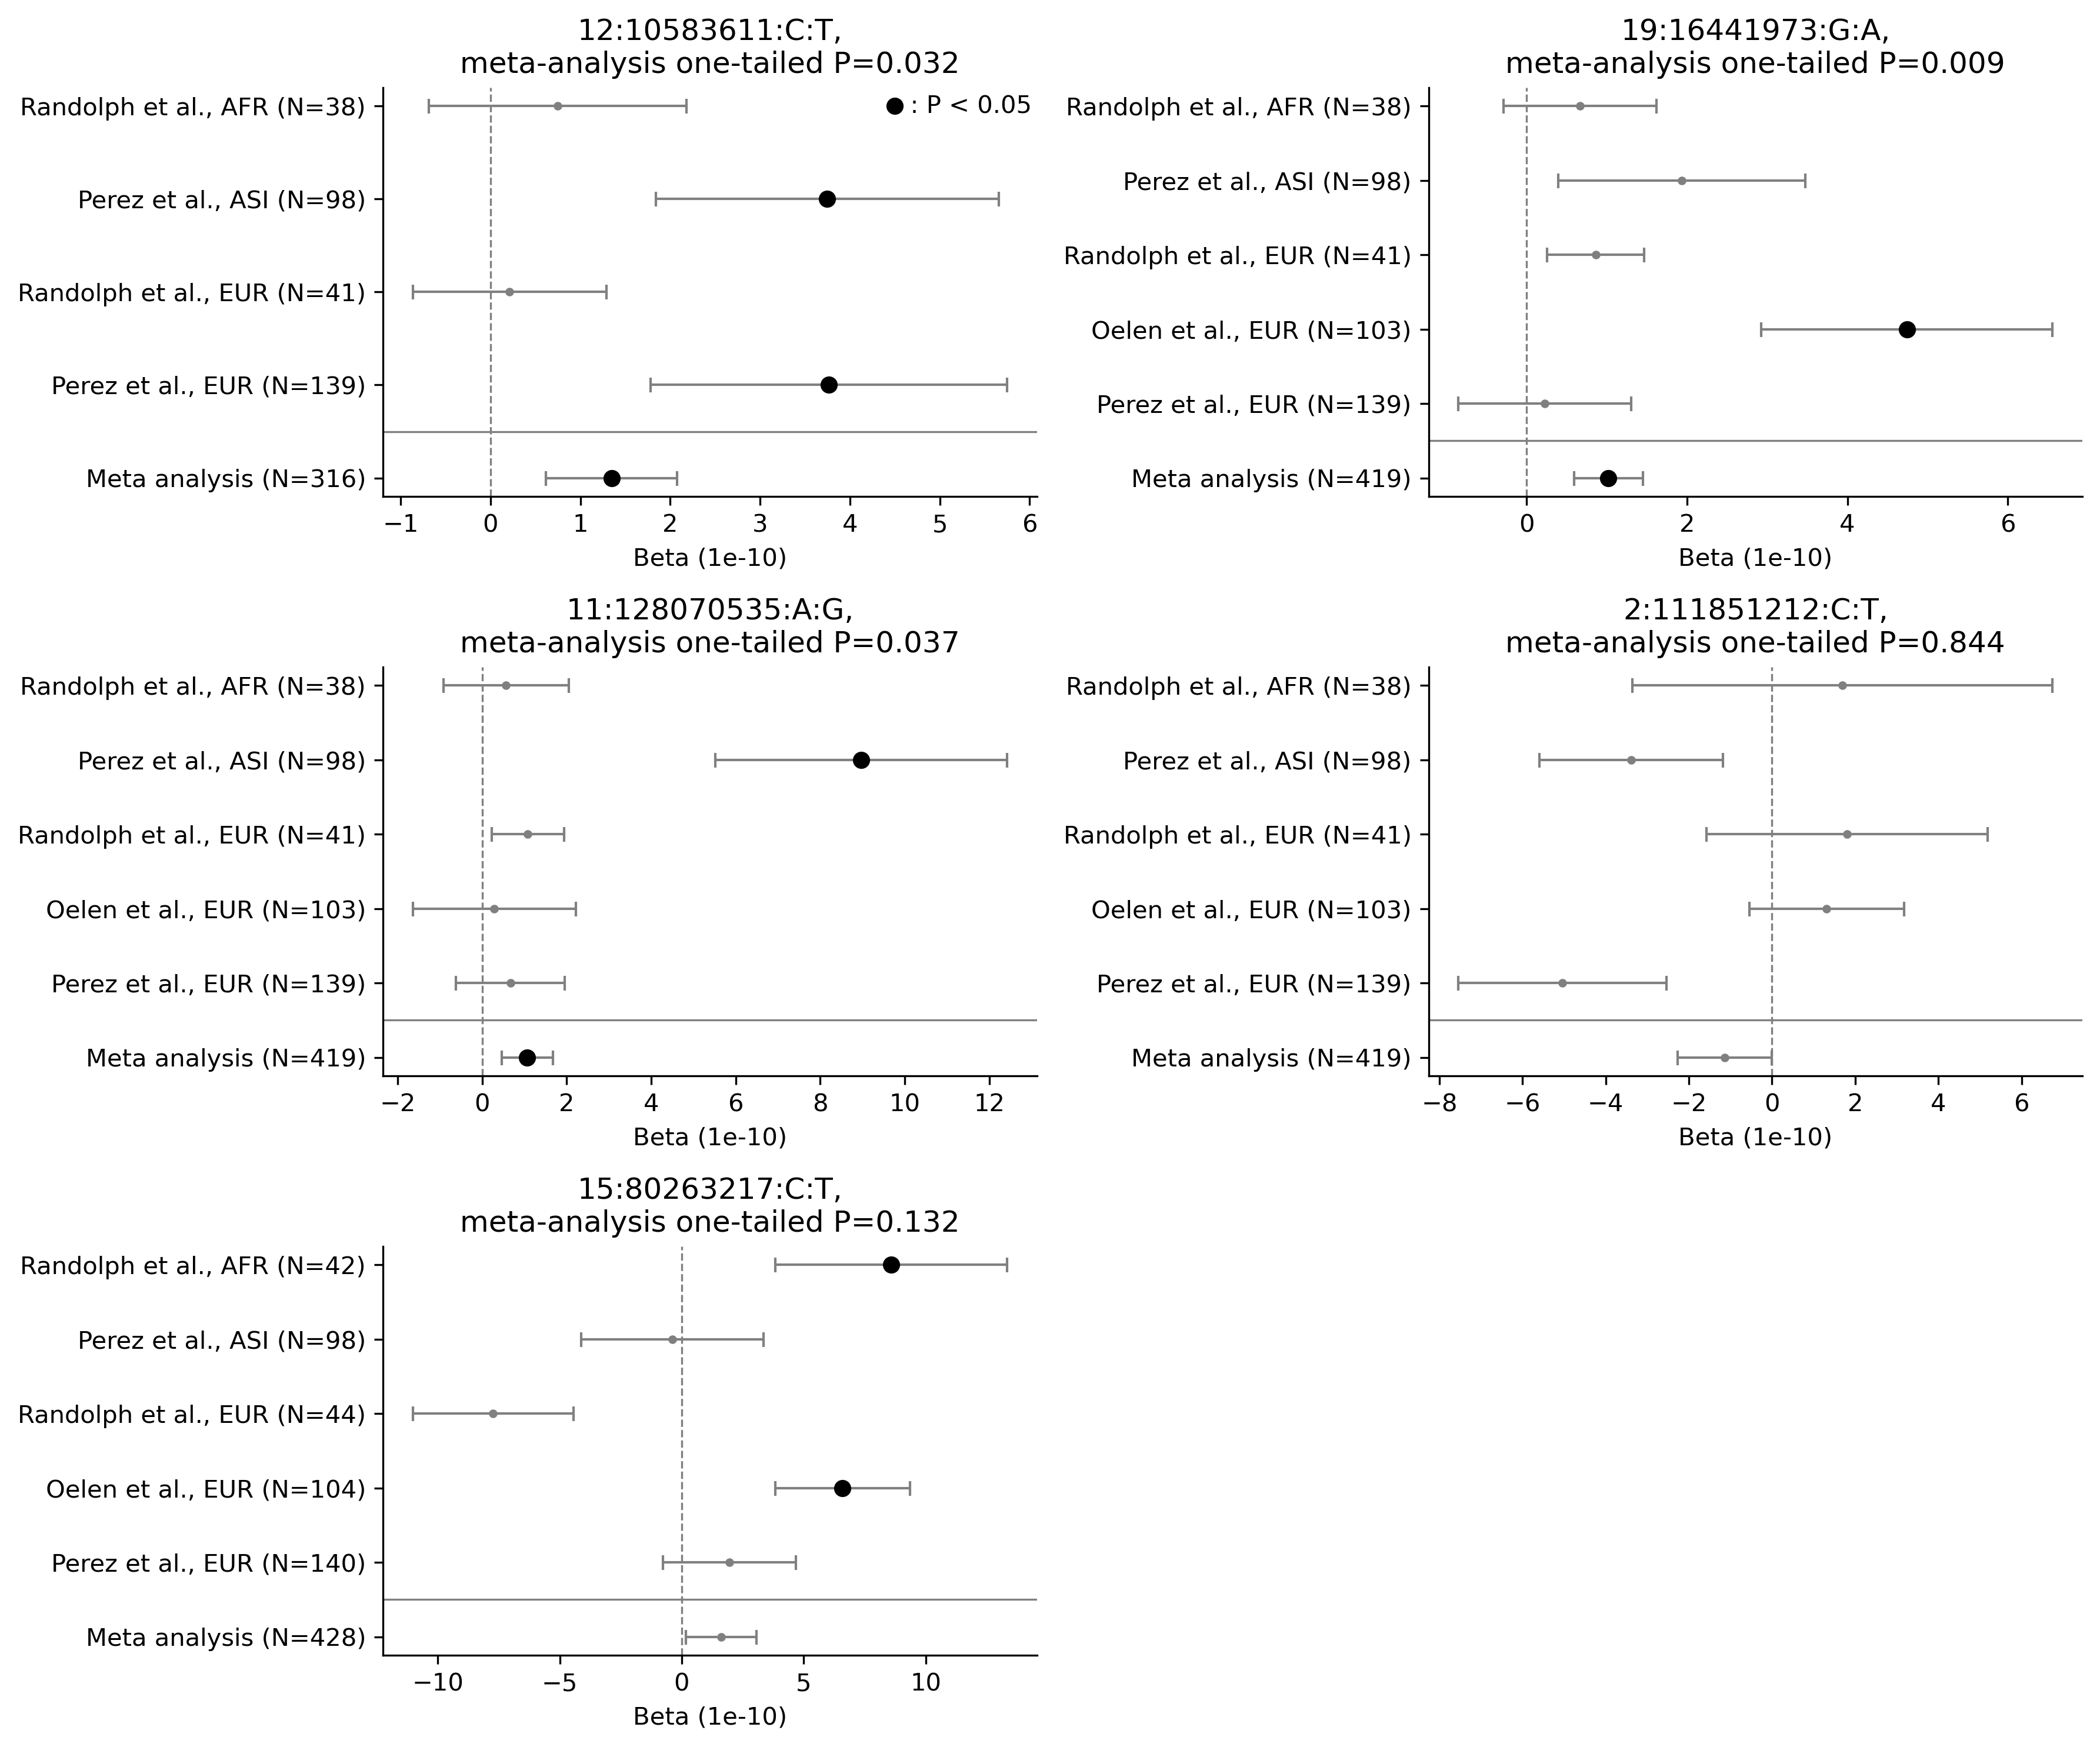

In [12]:
fig, axs = plt.subplots(3,2, figsize=(12,10), dpi = 300)
for i_ax, sel_snp in enumerate(['12:10583611:C:T', '19:16441973:G:A', '11:128070535:A:G', 
                                          '2:111851212:C:T','15:80263217:C:T']):
    mod_res = all_res.loc[all_res.lead_snp==sel_snp,:]
    mod_res.reset_index(inplace = True, drop = True)
    mod_res = mod_res.iloc[np.argsort(mod_res.cohort.values),:].reset_index(drop = True)
    mod_res['y'] = mod_res.index.values[::-1]
    
    ax = axs.reshape(-1,)[i_ax]
    ci = mod_res.stderr_mod.values
    ax.errorbar(x=mod_res.beta_mod.values, y=mod_res.y.values, xerr=ci,
                color='grey',  capsize=3, linestyle='None', linewidth=1,
                marker=".", markersize=5, mfc="grey", mec="grey")

    # remove top / right spines
    ax.spines[['right', 'top']].set_visible(False)
    
    if i_ax==0:
        ax.text(4.5,3.925, "  : P < 0.05")
        ax.scatter(4.5,4,marker = "o", c="black")
    
    for i in np.arange(mod_res.shape[0]):
        if mod_res.P[i]<0.05:
            ax.scatter(mod_res.beta_mod[i], mod_res.y[i], color='black', zorder = 20, marker = "o")
    
    ax.set_yticks(np.arange(mod_res.shape[0]))
    ax.set_yticklabels(mod_res.dset_cohort.values[::-1])
    ax.set_xlabel('Beta (1e-10)')
    
    ax.axvline(x=0, linewidth=0.8, linestyle='--', color='grey')
    ax.axhline(y=0.5, linewidth=0.8, linestyle='-', color='grey')

    meta_p = mod_res.loc[mod_res.dset=="Meta analysis","P"].values[0]
    ax.set_title(sel_snp+",\nmeta-analysis one-tailed P="+str(np.around(meta_p,3)))

axs[2,1].axis("off")    
plt.tight_layout()
plt.savefig(fig_dir+"replication_forest.png")

In [13]:
# Save for comparison
all_res_projection = all_res.copy()

# Test replication of two cell type ratio phenotypes using clusters

In [14]:
Myeloid_all_res = test_replication("Myeloid", ['15:80263217:C:T'], pheno_type="clusters")
NK_all_res = test_replication("NK", ['2:111851212:C:T'], pheno_type="clusters")
all_res = meta_analysis_assoc(pd.concat([Myeloid_all_res, NK_all_res]),
                             lead_snps = ['2:111851212:C:T','15:80263217:C:T'])

randolph EUR
randolph AFR


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


oelen EUR
perez_sle ASI


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


perez_sle EUR


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


randolph EUR
randolph AFR
oelen EUR


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


perez_sle ASI
perez_sle EUR


/PHShome/lar24/anaconda3/envs/py3_clone/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [15]:
# reformat results table
all_res.reset_index(inplace = True, drop = True)
all_res['beta_mod'] = all_res.beta.values/(1e-1)
all_res['stderr_mod'] = all_res.stderr.values/(1e-1)
all_res['hl'] = all_res.beta_mod.values+all_res.stderr_mod.values
all_res['ll'] = all_res.beta_mod.values-all_res.stderr_mod.values

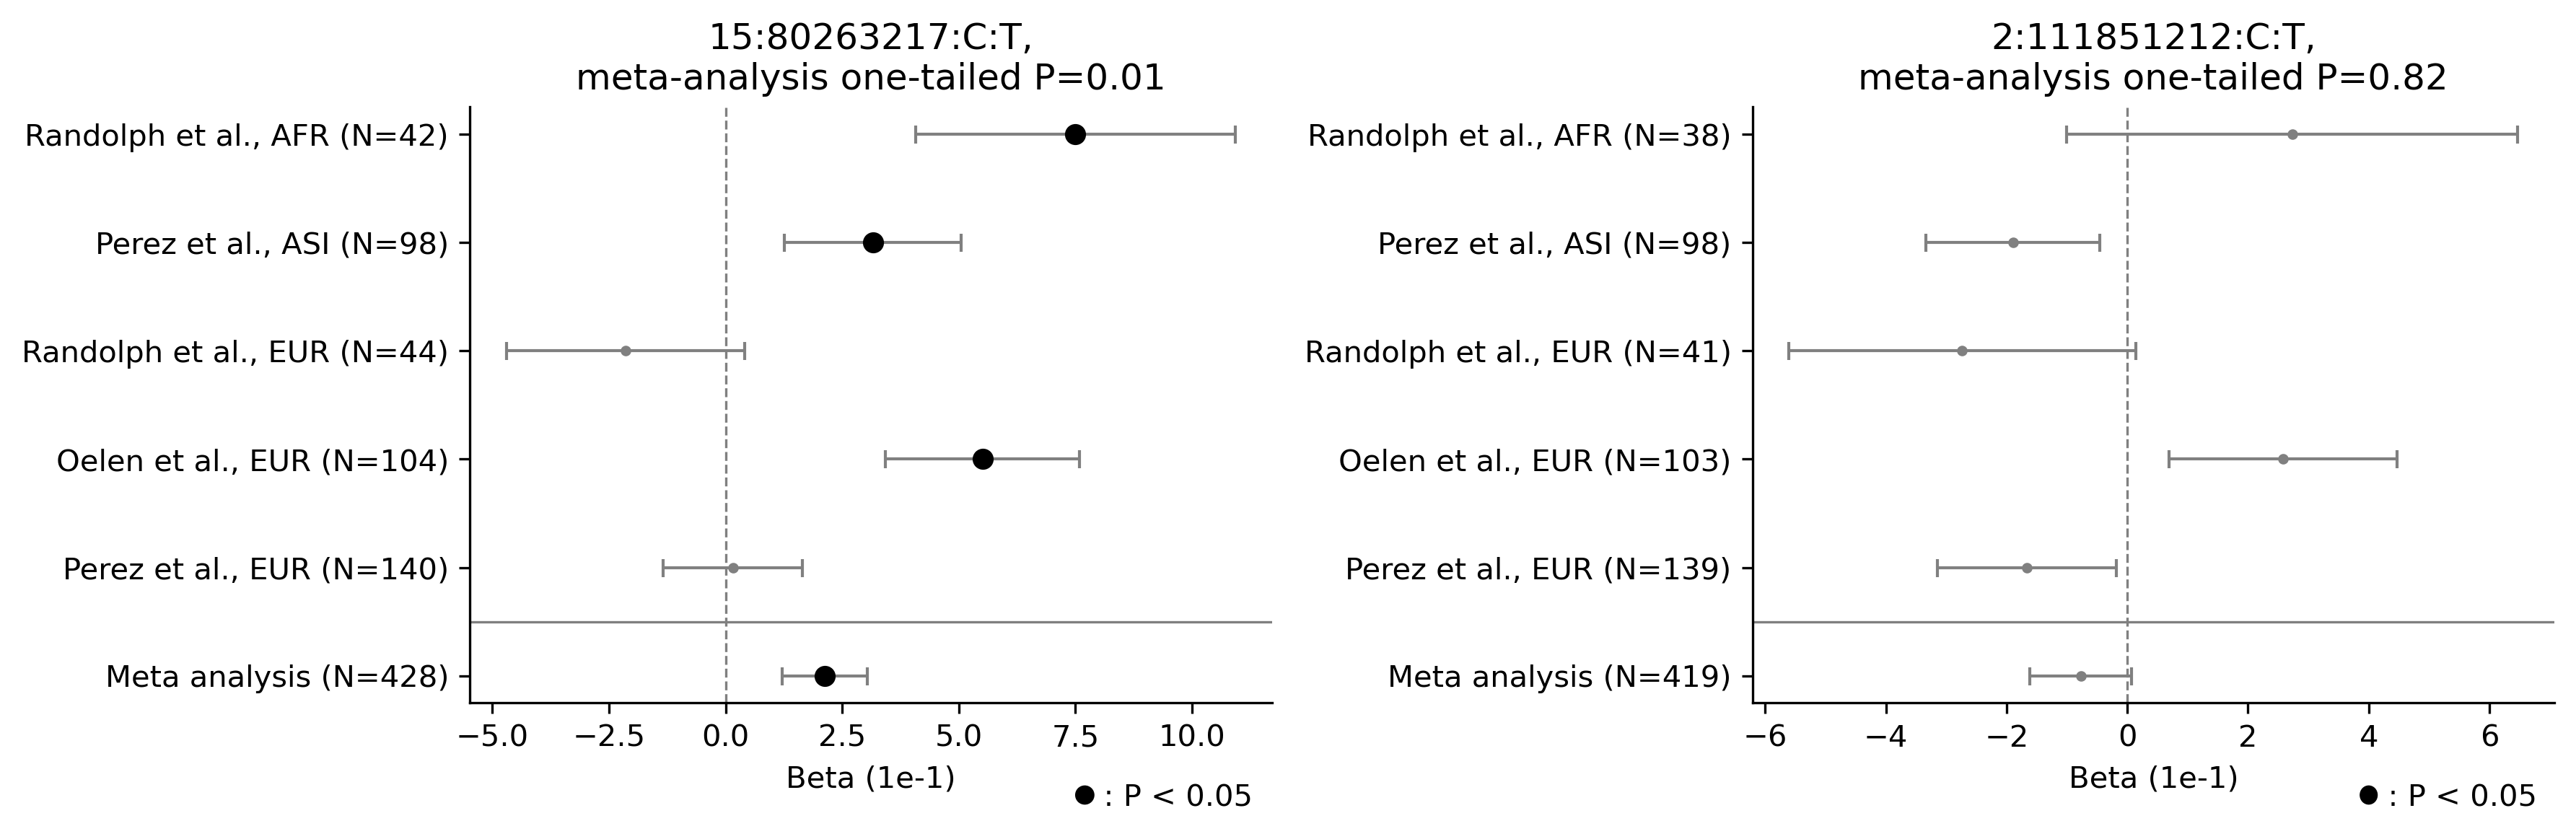

In [16]:
fig, axs = plt.subplots(1,2, figsize=(12,4), dpi = 300)
for i_ax, sel_snp in enumerate(['15:80263217:C:T', '2:111851212:C:T']):
    mod_res = all_res.loc[all_res.lead_snp==sel_snp,:]
    mod_res.reset_index(inplace = True, drop = True)
    mod_res = mod_res.iloc[np.argsort(mod_res.cohort.values),:].reset_index(drop = True)
    mod_res['y'] = mod_res.index.values[::-1]
    
    ax = axs.reshape(-1,)[i_ax]
    ci = mod_res.stderr_mod.values
    ax.errorbar(x=mod_res.beta_mod.values, y=mod_res.y.values, xerr=ci,
                color='grey',  capsize=3, linestyle='None', linewidth=1,
                marker=".", markersize=5, mfc="grey", mec="grey")
    
    for i in np.arange(mod_res.shape[0]):
        if mod_res.P[i]<0.05 and mod_res.beta_mod[i]>0:
            ax.scatter(mod_res.beta_mod[i], mod_res.y[i], color='black', zorder = 20, marker = "o")
    
    ax.set_yticks(np.arange(mod_res.shape[0]))
    ax.set_yticklabels(mod_res.dset_cohort.values[::-1])
    ax.set_xlabel('Beta (1e-1)') # 
    
    ax.axvline(x=0, linewidth=0.8, linestyle='--', color='grey')
    ax.axhline(y=0.5, linewidth=0.8, linestyle='-', color='grey')

    meta_p = mod_res.loc[mod_res.dset=="Meta analysis","P"].values[0]
    ax.set_title(sel_snp+",\nmeta-analysis one-tailed P="+str(np.around(meta_p,3)))
    
    # remove top / right spines
    ax.spines[['right', 'top']].set_visible(False)
    
    if i_ax==0:
        ax.text(7.7,-1.2, "  : P < 0.05", clip_on=False)
        circle1 = Ellipse((7.7,-1.1), 0.35, 0.15, color='black', clip_on=False)
        ax.add_patch(circle1)
    
    if i_ax==1:
        ax.text(4,-1.2, "  : P < 0.05")
        circle1 = Ellipse((4,-1.1), 0.25, 0.15, color='black', clip_on=False)
        ax.add_patch(circle1)
    
plt.tight_layout()
plt.savefig(fig_dir+"replication_forest_clusters.png")

In [17]:
# Save for comparison
all_res_clusters = all_res.copy()

## Visualize direct comparison of effect size estimates between approaches

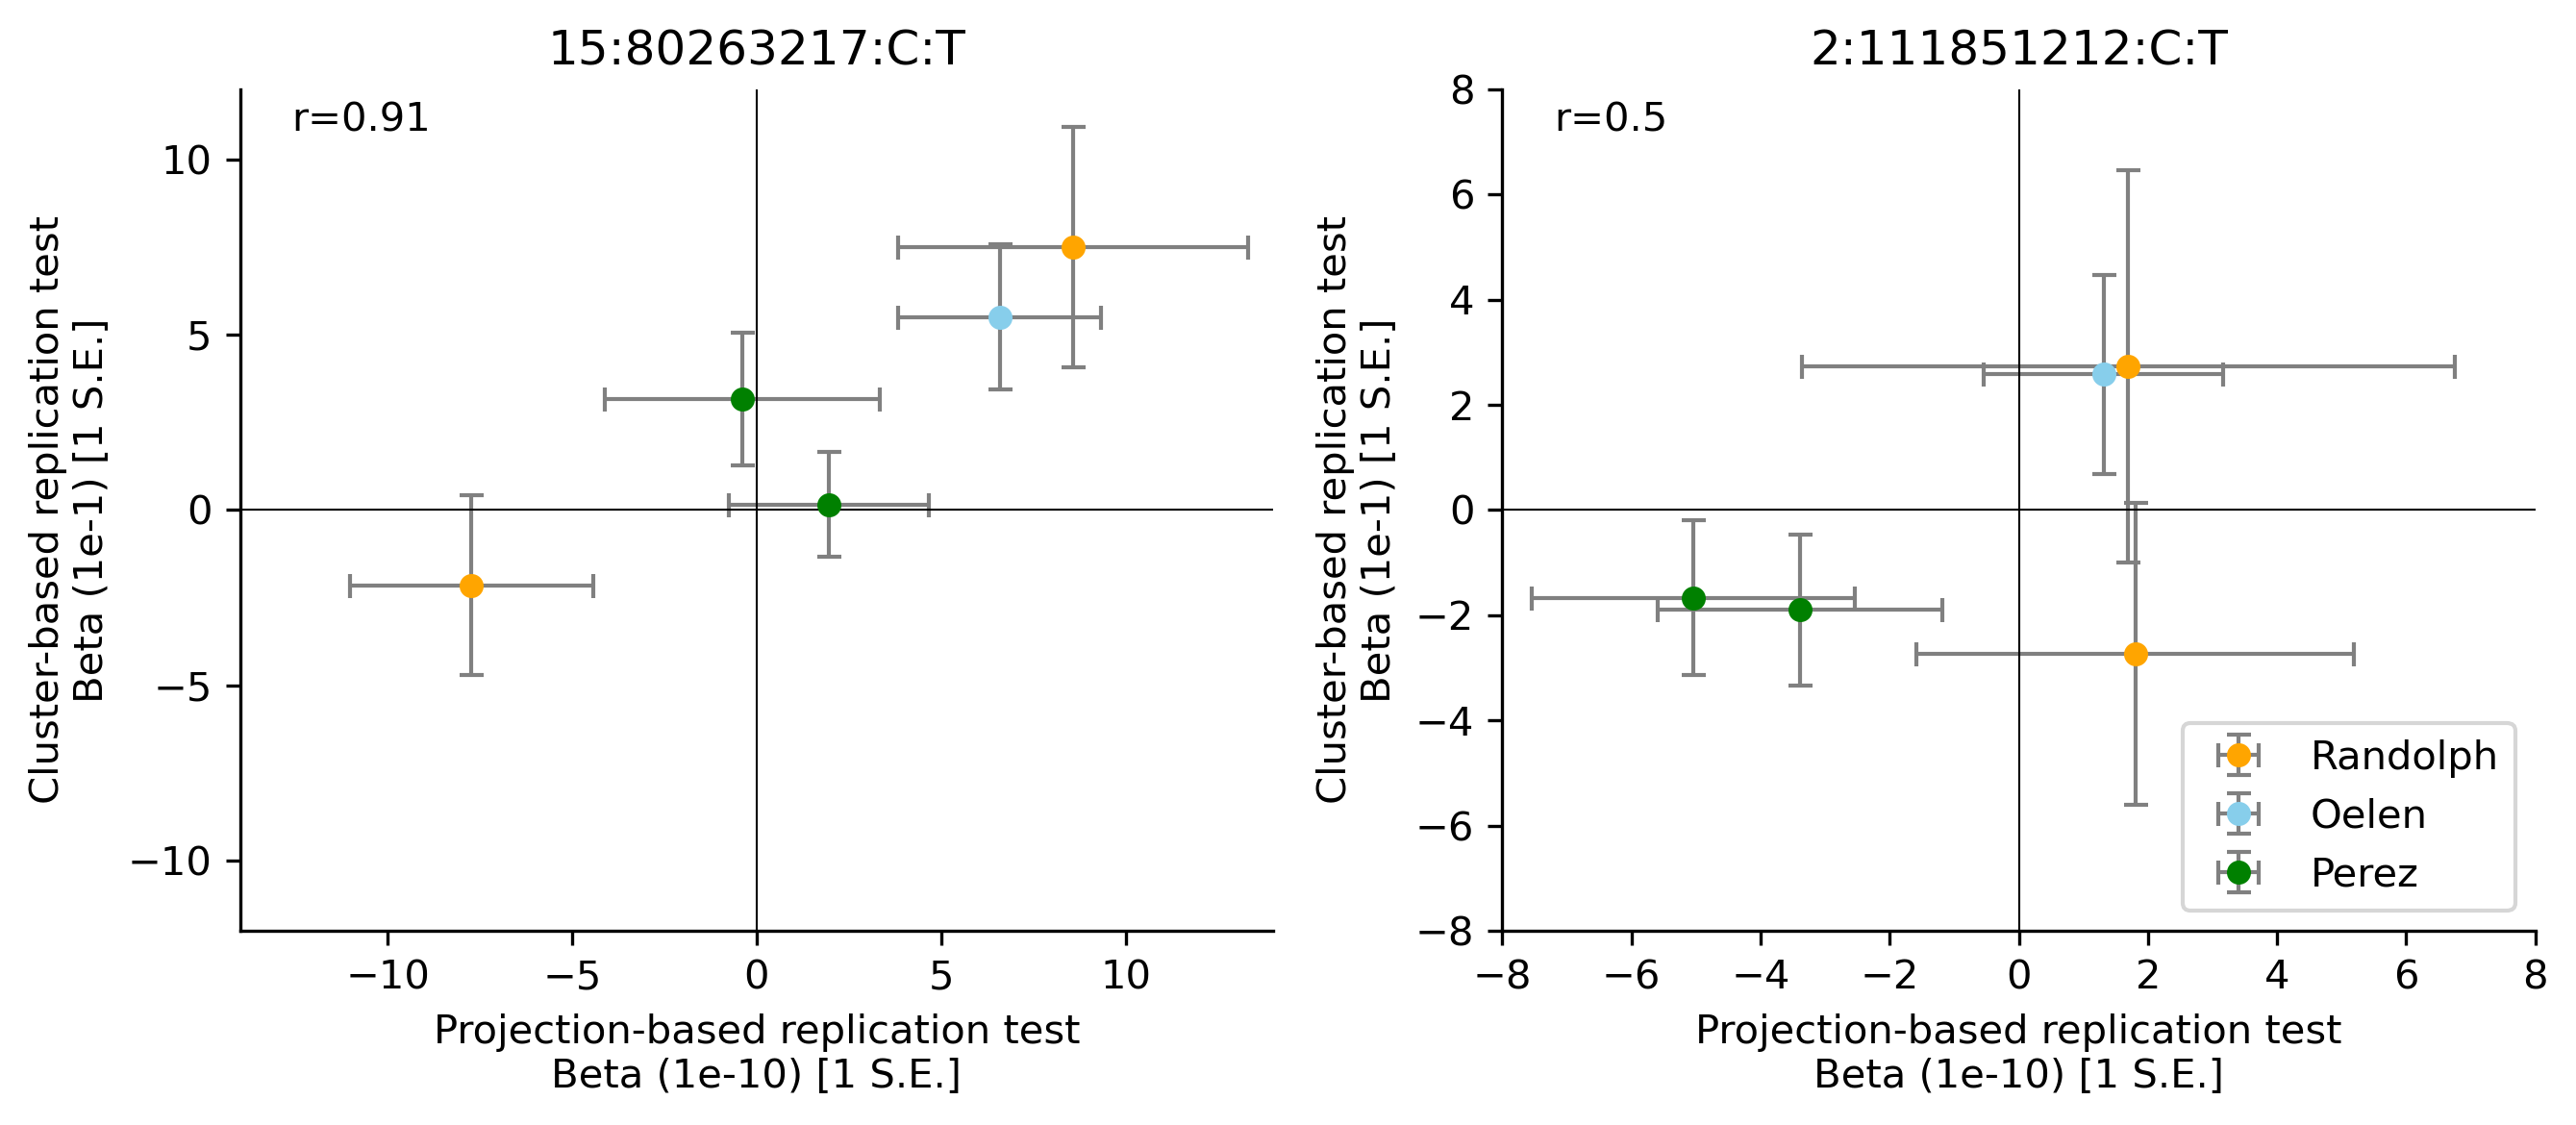

In [18]:
sel_colors = ['orange', 'skyblue', 'green']
fig, axs = plt.subplots(1,2, figsize=(9,4), dpi = 300)
for i_ax, sel_snp in enumerate(['15:80263217:C:T', '2:111851212:C:T']):
    ax = axs.reshape(-1,)[i_ax]
    projection = all_res_projection.loc[all_res_projection.lead_snp==sel_snp,:]
    projection = projection.loc[projection.dset!="Meta analysis",:]
    clusters = all_res_clusters.loc[all_res_clusters.lead_snp==sel_snp,:]
    meta_p = clusters.loc[clusters.dset=="Meta analysis",:].P.values[0]
    meta_beta = clusters.loc[clusters.dset=="Meta analysis",:].beta.values[0]
    clusters  = clusters.loc[clusters .dset!="Meta analysis",:]
    for i, dset in enumerate(['randolph', 'oelen', 'perez_sle']):
        mask = projection.dset==dset
        ax.errorbar(x=projection.beta_mod.values[mask], xerr=projection.stderr_mod.values[mask],
             y=clusters.beta_mod.values[mask], yerr=clusters.stderr_mod.values[mask],
                color='grey',  capsize=3, linestyle='None', linewidth=1,
                marker=".", markersize=10, mfc=sel_colors[i], mec=sel_colors[i], 
                    label = dset.capitalize().split("_sle")[0])
    if i_ax==1:
        ax.set_xlim([-8, 8])
        ax.set_ylim([-8, 8])
        ax.legend(loc='lower right')
    else:
        ax.set_xlim([-14, 14])
        ax.set_ylim([-12, 12])
    ax.axhline(y=0, c = "black",lw=0.5)
    ax.axvline(x=0, c = "black",lw=0.5)
    ax.set_xlabel("Projection-based replication test\nBeta (1e-10) [1 S.E.]")
    ax.set_ylabel("Cluster-based replication test\nBeta (1e-1) [1 S.E.]")
    
    ax.set_title(sel_snp)
    beta_cor = np.corrcoef(projection.beta_mod.values, clusters.beta_mod.values)[0,1]
    ax.text(0.05,0.95,"r="+str(np.around(beta_cor, 2)), transform=ax.transAxes)
    
    # remove top / right spines
    ax.spines[['right', 'top']].set_visible(False)
    
plt.tight_layout()
plt.savefig(fig_dir+"replication_projection_vs_clusters.png")
plt.show()